# ShuffleNetV2实现灾害识别
该项目可以判断灾害的类别，类别包括：倒塌的建筑物、火灾、正常、洪水和交通事故。更好的调度救灾资源。

In [1]:
%%capture captured_output
# 实验环境已经预装了mindspore==2.5.0，如需更换mindspore版本，可更改下面 MINDSPORE_VERSION 变量
!pip uninstall mindspore -y
%env MINDSPORE_VERSION=2.5.0
!pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/${MINDSPORE_VERSION}/MindSpore/unified/aarch64/mindspore-${MINDSPORE_VERSION}-cp39-cp39-linux_aarch64.whl --trusted-host ms-release.obs.cn-north-4.myhuaweicloud.com -i https://pypi.tuna.tsinghua.edu.cn/simple

In [2]:
# 查看当前 mindspore 版本
!pip show mindspore

Name: mindspore
Version: 2.5.0
Summary: MindSpore is a new open source deep learning training/inference framework that could be used for mobile, edge and cloud scenarios.
Home-page: https://www.mindspore.cn
Author: The MindSpore Authors
Author-email: contact@mindspore.cn
License: Apache 2.0
Location: /home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages
Requires: asttokens, astunparse, dill, numpy, packaging, pillow, protobuf, psutil, safetensors, scipy
Required-by: 


In [3]:
!git lfs install
!git clone https://modelers.cn/xsir/AIDER.git
!unzip -q ./AIDER/dataset.zip -d ./AIDER

Git LFS initialized.
正克隆到 'AIDER'...
remote: Enumerating objects: 6429, done.
remote: Counting objects: 100% (6429/6429), done.
remote: Compressing objects: 100% (6428/6428), done.
remote: Total 6429 (delta 1), reused 6425 (delta 0), pack-reused 0
接收对象中: 100% (6429/6429), 261.49 MiB | 15.13 MiB/s, 完成.
处理 delta 中: 100% (1/1), 完成.


In [3]:
import os

import mindspore as ms
from mindspore.dataset import ImageFolderDataset
import mindspore.dataset.vision as transforms


data_path = './AIDER/dataset/'
mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
std = [0.229 * 255, 0.224 * 255, 0.225 * 255]

dataset_train = ImageFolderDataset(os.path.join(data_path, "train"), shuffle=True)

trans_train = [
    transforms.RandomCropDecodeResize(size=224,
                                      scale=(0.08, 1.0),
                                      ratio=(0.75, 1.333)),
    transforms.RandomHorizontalFlip(prob=0.5),
    transforms.Normalize(mean=mean, std=std),
    transforms.HWC2CHW()
]

dataset_train = dataset_train.map(operations=trans_train, input_columns=["image"])
dataset_train = dataset_train.batch(batch_size=16, drop_remainder=True)

/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


## ShuffleNetV2模型架构

In [4]:
import numpy as np

from mindspore import Tensor
import mindspore.nn as nn
import mindspore.ops.operations as P

class ShuffleV2Block(nn.Cell):
    def __init__(self, inp, oup, mid_channels, *, ksize, stride):
        super(ShuffleV2Block, self).__init__()
        self.stride = stride
        ##assert stride in [1, 2]

        self.mid_channels = mid_channels
        self.ksize = ksize
        pad = ksize // 2
        self.pad = pad
        self.inp = inp

        outputs = oup - inp

        branch_main = [
            # pw
            nn.Conv2d(in_channels=inp, out_channels=mid_channels, kernel_size=1, stride=1,
                      pad_mode='pad', padding=0, has_bias=False),
            nn.BatchNorm2d(num_features=mid_channels, momentum=0.9),
            nn.ReLU(),
            # dw
            nn.Conv2d(in_channels=mid_channels, out_channels=mid_channels, kernel_size=ksize, stride=stride,
                      pad_mode='pad', padding=pad, group=mid_channels, has_bias=False),

            nn.BatchNorm2d(num_features=mid_channels, momentum=0.9),
            # pw-linear
            nn.Conv2d(in_channels=mid_channels, out_channels=outputs, kernel_size=1, stride=1,
                      pad_mode='pad', padding=0, has_bias=False),
            nn.BatchNorm2d(num_features=outputs, momentum=0.9),
            nn.ReLU(),
        ]
        self.branch_main = nn.SequentialCell(branch_main)

        if stride == 2:
            branch_proj = [
                # dw
                nn.Conv2d(in_channels=inp, out_channels=inp, kernel_size=ksize, stride=stride,
                          pad_mode='pad', padding=pad, group=inp, has_bias=False),
                nn.BatchNorm2d(num_features=inp, momentum=0.9),
                # pw-linear
                nn.Conv2d(in_channels=inp, out_channels=inp, kernel_size=1, stride=1,
                          pad_mode='pad', padding=0, has_bias=False),
                nn.BatchNorm2d(num_features=inp, momentum=0.9),
                nn.ReLU(),
            ]
            self.branch_proj = nn.SequentialCell(branch_proj)
        else:
            self.branch_proj = None
        self.squeeze = P.Squeeze(axis=0)

    def construct(self, old_x):
        if self.stride == 1:
            x_proj, x = self.channel_shuffle(old_x)
            x_proj = self.squeeze(x_proj)
            x = self.squeeze(x)
            return P.Concat(1)((x_proj, self.branch_main(x)))
        if self.stride == 2:
            x_proj = old_x
            x = old_x
            return P.Concat(1)((self.branch_proj(x_proj), self.branch_main(x)))
        return None

    def channel_shuffle(self, x):
        batchsize, num_channels, height, width = P.Shape()(x)
        x = P.Reshape()(x, (batchsize * num_channels // 2, 2, height * width,))
        x = P.Transpose()(x, (1, 0, 2,))
        x = P.Reshape()(x, (2, -1, num_channels // 2, height, width,))
        return x[0:1, :, :, :, :], x[-1:, :, :, :, :]


class ShuffleNetV2(nn.Cell):
    def __init__(self, input_size=224, n_class=1000, model_size='1.0x'):
        super(ShuffleNetV2, self).__init__()
        print('model size is ', model_size)

        self.stage_repeats = [4, 8, 4]
        self.model_size = model_size
        if model_size == '0.5x':
            self.stage_out_channels = [-1, 24, 48, 96, 192, 1024]
        elif model_size == '1.0x':
            self.stage_out_channels = [-1, 24, 116, 232, 464, 1024]
        elif model_size == '1.5x':
            self.stage_out_channels = [-1, 24, 176, 352, 704, 1024]
        elif model_size == '2.0x':
            self.stage_out_channels = [-1, 24, 244, 488, 976, 2048]
        else:
            raise NotImplementedError

        # building first layer
        input_channel = self.stage_out_channels[1]
        self.first_conv = nn.SequentialCell([
            nn.Conv2d(in_channels=3, out_channels=input_channel, kernel_size=3, stride=2,
                      pad_mode='pad', padding=1, has_bias=False),
            nn.BatchNorm2d(num_features=input_channel, momentum=0.9),
            nn.ReLU(),
        ])

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode='same')

        self.features = []
        for idxstage in range(len(self.stage_repeats)):
            numrepeat = self.stage_repeats[idxstage]
            output_channel = self.stage_out_channels[idxstage+2]

            for i in range(numrepeat):
                if i == 0:
                    self.features.append(ShuffleV2Block(input_channel, output_channel,
                                                        mid_channels=output_channel // 2, ksize=3, stride=2))
                else:
                    self.features.append(ShuffleV2Block(input_channel // 2, output_channel,
                                                        mid_channels=output_channel // 2, ksize=3, stride=1))

                input_channel = output_channel

        self.features = nn.SequentialCell([*self.features])

        self.conv_last = nn.SequentialCell([
            nn.Conv2d(in_channels=input_channel, out_channels=self.stage_out_channels[-1], kernel_size=1, stride=1,
                      pad_mode='pad', padding=0, has_bias=False),
            nn.BatchNorm2d(num_features=self.stage_out_channels[-1], momentum=0.9),
            nn.ReLU()
        ])
        self.globalpool = nn.AvgPool2d(kernel_size=7, stride=7, pad_mode='valid')
        if self.model_size == '2.0x':
            self.dropout = nn.Dropout(p=0.2)
        self.classifier = nn.SequentialCell([nn.Dense(in_channels=self.stage_out_channels[-1],
                                                      out_channels=n_class, has_bias=False)])
        ## init weights
        self._initialize_weights()

    def construct(self, x):
        x = self.first_conv(x)
        x = self.maxpool(x)
        x = self.features(x)

        x = self.conv_last(x)

        x = self.globalpool(x)
        if self.model_size == '2.0x':
            x = self.dropout(x)
        x = P.Reshape()(x, (-1, self.stage_out_channels[-1],))
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for name, m in self.cells_and_names():
            if isinstance(m, nn.Conv2d):
                if 'first' in name:
                    m.weight.set_data(Tensor(np.random.normal(0, 0.01,
                                                              m.weight.data.shape).astype("float32")))
                else:
                    m.weight.set_data(Tensor(np.random.normal(0, 1.0/m.weight.data.shape[1],
                                                              m.weight.data.shape).astype("float32")))

            if isinstance(m, nn.Dense):
                m.weight.set_data(Tensor(np.random.normal(0, 0.01, m.weight.data.shape).astype("float32")))


## 模型训练与推理

### 模型训练

模型开始训练前，需要设定损失函数，优化器，回调函数等。

完整训练该模型需要很长的时间，实际应用时建议根据项目需要调整epoch_size，当正常输出每个Epoch的step信息时，意味着训练正在进行，通过模型输出可以查看当前训练的loss值和时间等指标。

In [5]:
# 定义网络
network = ShuffleNetV2(n_class=5)

model size is  1.0x


In [ ]:
%%time
from mindspore.nn import LossBase
from mindspore.train import LossMonitor, TimeMonitor, CheckpointConfig, ModelCheckpoint
from mindspore import train, ops

# define super parameter
epoch_size = 8
momentum = 0.9
num_classes = 5
resize = 224
step_size = dataset_train.get_dataset_size()


# define learning rate
lr = nn.cosine_decay_lr(min_lr=float(0),
                        max_lr=0.00005,
                        total_step=epoch_size * step_size,
                        step_per_epoch=step_size,
                        decay_epoch=10)

# define optimizer
network_opt = nn.Adam(network.trainable_params(), lr, momentum)


# define loss function
class CrossEntropySmooth(LossBase):
    """CrossEntropy."""

    def __init__(self, sparse=True, reduction='mean', smooth_factor=0., num_classes=1000):
        super(CrossEntropySmooth, self).__init__()
        self.onehot = ops.OneHot()
        self.sparse = sparse
        self.on_value = ms.Tensor(1.0 - smooth_factor, ms.float32)
        self.off_value = ms.Tensor(1.0 * smooth_factor / (num_classes - 1), ms.float32)
        self.ce = nn.SoftmaxCrossEntropyWithLogits(reduction=reduction)

    def construct(self, logit, label):
        if self.sparse:
            label = self.onehot(label, ops.shape(logit)[1], self.on_value, self.off_value)
        loss = self.ce(logit, label)
        return loss


network_loss = CrossEntropySmooth(sparse=True,
                                  reduction="mean",
                                  smooth_factor=0.1,
                                  num_classes=num_classes)

# set checkpoint
ckpt_config = CheckpointConfig(save_checkpoint_steps=step_size, keep_checkpoint_max=5)
ckpt_callback = ModelCheckpoint(prefix='shufflenetv2', directory='./shufflenetv2', config=ckpt_config)

# initialize model
# Not using mixed precision

model = train.Model(network, loss_fn=network_loss, optimizer=network_opt, metrics={"acc"}, amp_level="O0")

# train model
model.train(epoch_size,
            dataset_train,
            callbacks=[ckpt_callback, LossMonitor(step_size), TimeMonitor(step_size)],
            dataset_sink_mode=False,)

/usr/local/Ascend/ascend-toolkit/8.0.0/opp/built-in/op_impl/ai_core/tbe/impl/util/util_conv2d_dynamic.py:130: UserWarning: conv2d fmap ori_range changed from [[16, 31], [1024, 1024], [7, 15], [7, 15]] to [[16, 31], [1024, 1024], [7, 15], (7, 15)].
  warnings.warn(to_print)


...epoch: 1 step: 369, loss is 1.222536563873291
Train epoch time: 105134.850 ms, per step time: 284.918 ms
epoch: 2 step: 369, loss is 1.123945713043213
Train epoch time: 62811.223 ms, per step time: 170.220 ms
epoch: 3 step: 369, loss is 0.6887292861938477
Train epoch time: 62065.155 ms, per step time: 168.198 ms
epoch: 4 step: 369, loss is 1.0091545581817627
Train epoch time: 62837.561 ms, per step time: 170.291 ms
epoch: 5 step: 369, loss is 0.8302930593490601
Train epoch time: 62495.860 ms, per step time: 169.365 ms
epoch: 6 step: 369, loss is 0.8773775100708008
Train epoch time: 62612.015 ms, per step time: 169.680 ms
epoch: 7 step: 369, loss is 0.8106091022491455
Train epoch time: 62052.527 ms, per step time: 168.164 ms
epoch: 8 step: 369, loss is 0.6699323654174805
Train epoch time: 61294.663 ms, per step time: 166.110 ms
CPU times: user 43min 5s, sys: 2min 5s, total: 45min 10s
Wall time: 9min 1s


### 模型验证

模型验证过程主要应用了ImageFolderDataset，CrossEntropySmooth和Model等接口。

ImageFolderDataset主要用于读取数据集。

CrossEntropySmooth是损失函数实例化接口。

Model主要用于编译模型。

与训练过程相似，首先进行数据增强，然后定义ShuffleNetV2网络结构，加载预训练模型参数。随后设置损失函数，评价指标等，编译模型后进行验证。本案例采用了业界通用的评价标准Top_1_Accuracy评价指标来评价模型表现。

In [7]:
dataset_val = ImageFolderDataset(os.path.join(data_path, "val"), shuffle=True)

trans_val = [
    transforms.Decode(),
    transforms.Resize(224 + 32),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=mean, std=std),
    transforms.HWC2CHW()
]

dataset_val = dataset_val.map(operations=trans_val, input_columns=["image"])
dataset_val = dataset_val.batch(batch_size=16, drop_remainder=True)

network_loss = CrossEntropySmooth(sparse=True,
                                  reduction="mean",
                                  smooth_factor=0.1,
                                  num_classes=num_classes)

# define metric
eval_metrics = {'Top_1_Accuracy': train.Top1CategoricalAccuracy()}

if ascend_target:
    model = train.Model(network, loss_fn=network_loss, optimizer=network_opt, metrics=eval_metrics, amp_level="O2")
else:
    model = train.Model(network, loss_fn=network_loss, optimizer=network_opt, metrics=eval_metrics, amp_level="O0")

# evaluate model
result = model.eval(dataset_val)
print(result)

.{'Top_1_Accuracy': 0.6431451612903226}


### 模型推理


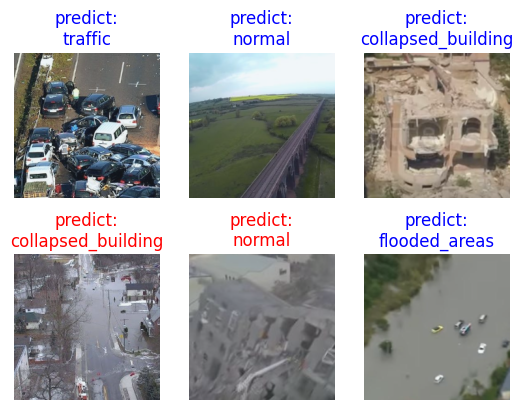

In [8]:
import matplotlib.pyplot as plt
import numpy as np
data = next(dataset_val.create_dict_iterator())
images = data["image"]
labels = data["label"]
output = network(data['image'])
pred = np.argmax(output.asnumpy(), axis=1)

# 图像分类
classes = ["collapsed_building", "fire", "flooded_areas", "normal", "traffic"]

# 显示图像及图像的预测值

plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    # 若预测正确，显示为蓝色；若预测错误，显示为红色
    color = 'blue' if pred[i] == labels.asnumpy()[i] else 'red'
    plt.title('predict:\n{}'.format(classes[pred[i]]), color=color)
    picture_show = np.transpose(images.asnumpy()[i], (1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    picture_show = std * picture_show + mean
    picture_show = np.clip(picture_show, 0, 1)
    plt.imshow(picture_show)
    plt.axis('off')

plt.show()